# Predicting housing prices

For this project, I use publicly available data on houses to build a regression model to predict housing prices, and use outlier detection to pick out unusual cases.

In [2]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats

import sklearn as sk
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from matplotlib import rcParams

print('Python version: %s.%s.%s' % sys.version_info[:3])
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sk.__version__)

import warnings
warnings.filterwarnings("ignore")

Python version: 3.5.2
numpy version: 1.12.0
pandas version: 0.19.2
scikit-learn version: 0.18.1


In [ ]:
class EstimatorSelectionHelper:
    
    """
    A helper class for running parameter grid search across different models. 
    It takes two dictionaries. The first contains the models to be scored. 
    The second contains the parameters for each model.
    """
    
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}
    
    """
    fit(X,y) method runs a parameter grid search with cross validation for each model
    and for the given training data. If scoring=None, the score method of the estimator is used.
    """
    
    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False): 
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs, 
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X,y)
            self.grid_searches[key] = gs 
            
    """
    After calling fit(X,y), the score_summary() method returns a df with a summary of the scores
    """
    
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
                }

            return pd.Series(dict(list( params.items()) + list(d.items() ))) #sum up two dicts
                      
        rows = [row(k, gsc.cv_validation_scores, gsc.parameters) 
                for k in self.keys
                for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)
        
        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        
        return df[columns]
        

## Exploring the data

This dataset contains information about 506 houses in a suburb of Boston, and contains 13 features: 

1. CRIM: per capita crime rate by town 
2. ZN: proportion of residential land zoned for lots over 25,000 sq.ft. 
3. INDUS: proportion of non-retail business acres per town 
4. CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) 
5. NOX: nitric oxides concentration (parts per 10 million) 
6. RM: average number of rooms per dwelling 
7. AGE: proportion of owner-occupied units built prior to 1940 
8. DIS: weighted distances to five Boston employment centres 
9. RAD: index of accessibility to radial highways 
10. TAX: full-value property-tax rate
11. PTRATIO: pupil-teacher ratio by town 
12. B: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town 
13. LSTAT: percent lower status of the population 
14. MEDV: Median value of owner-occupied homes in $1000's

MEDV will be our target variable.

We have 506 samples in total.

In [ ]:
bos = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None, sep='\s+')
bos.columns = ['CRIM', 'ZN', 'INDUS','CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO',
                 'B', 'LSTAT', 'MEDV']

### View pairwise plots between different features

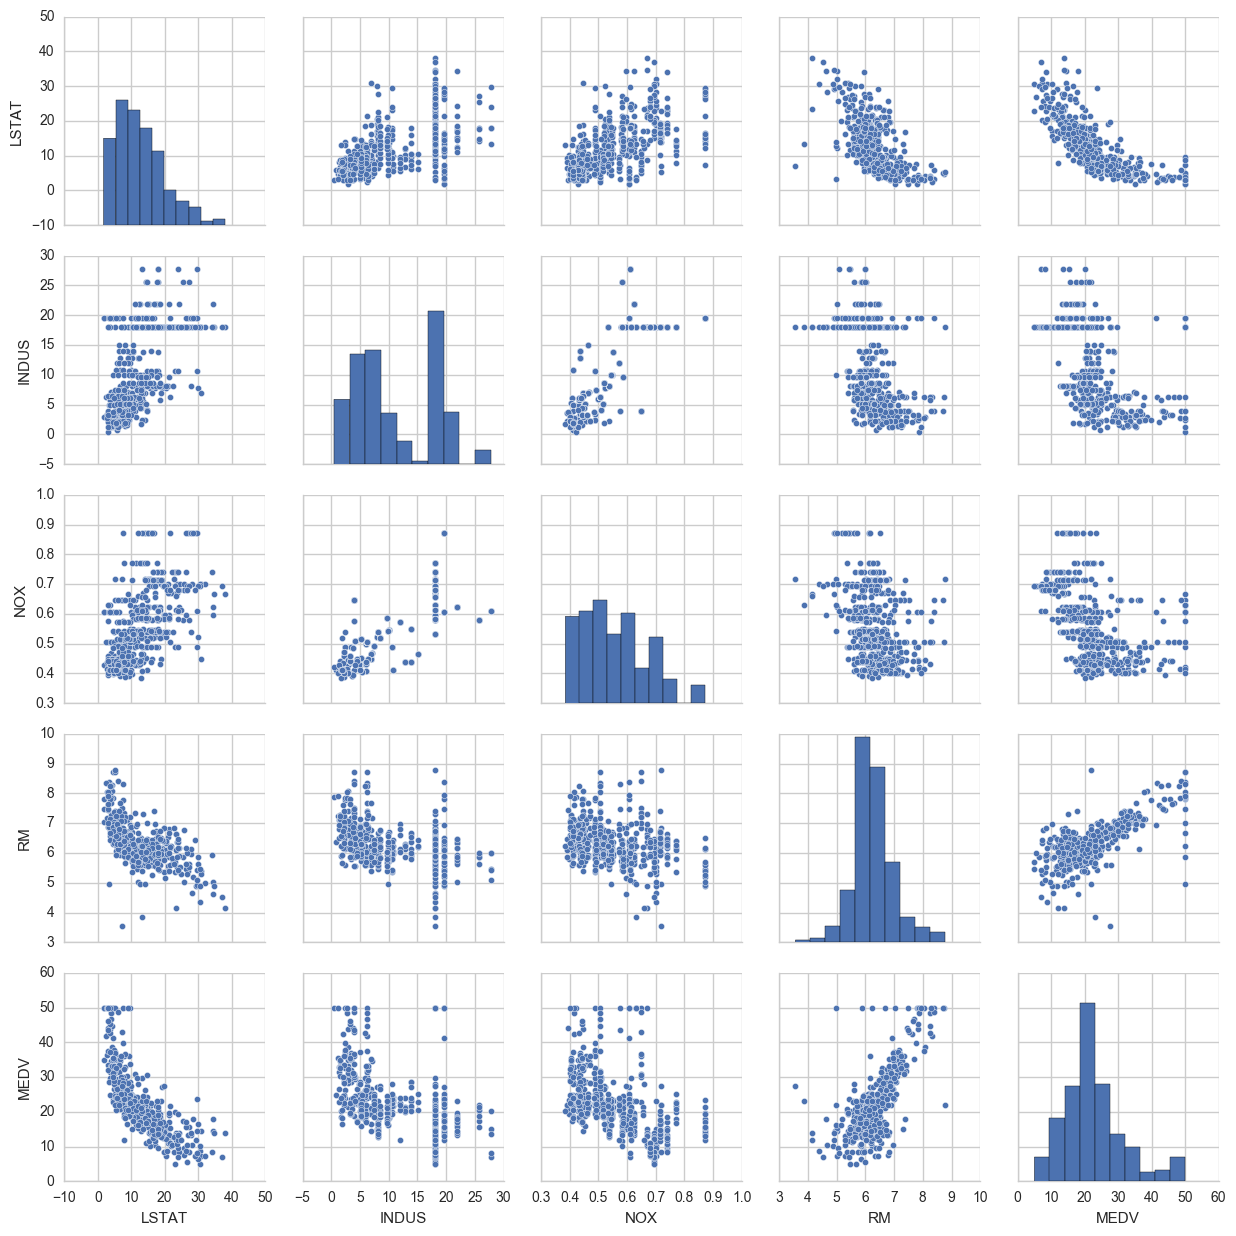

In [4]:
sns.set(style='whitegrid',context='notebook')
cols=['LSTAT','INDUS','NOX','RM','MEDV']
sns.pairplot(bos[cols],size=2.5)
plt.show()

Some things to note: 'RM' is the average number of rooms per dwelling. Unsurprisingly, there is a positive linear relationship between RM and MEDV (price).

LSTAT is the percentage lower status of the population. There is an inverse relationship with MEDV.

We can also see that MEDV is roughly normally distrubuted, but with some outliers.

### A correlation matrix to quantify linear relaionship between the features

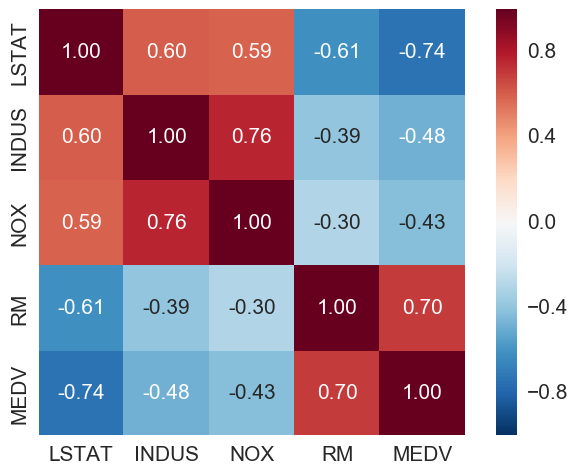

In [5]:
cm = np.corrcoef(bos[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':15},
                yticklabels=cols,
                xticklabels=cols)
plt.show()

LSTAT (percentage lower status) is the most negatively correlated with MEDV (house price). RM (number of rooms) is the only one here with positive correlation with MEDV.

### Looking more closely at some of the features...

#### Price vs RM
Price increases linearly with number of rooms, but there are some outliers.

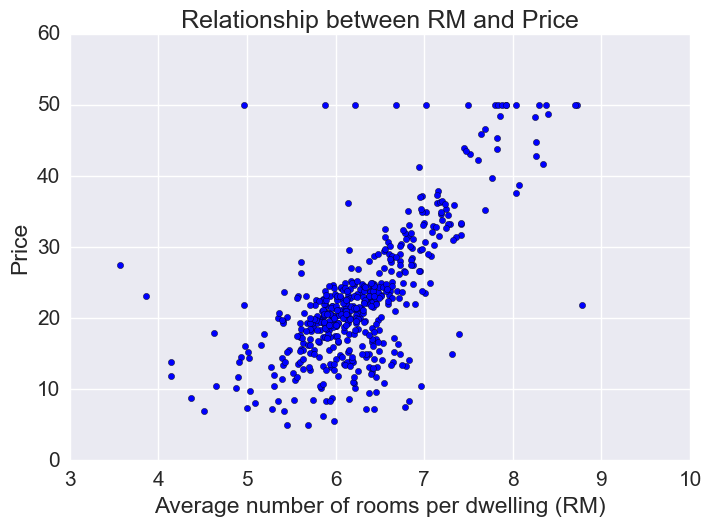

In [6]:
# Plot price vs average number of rooms
plt.scatter(bos.RM, bos.MEDV)
plt.xlabel("Average number of rooms per dwelling (RM)")
plt.ylabel("Price")
plt.title("Relationship between RM and Price")

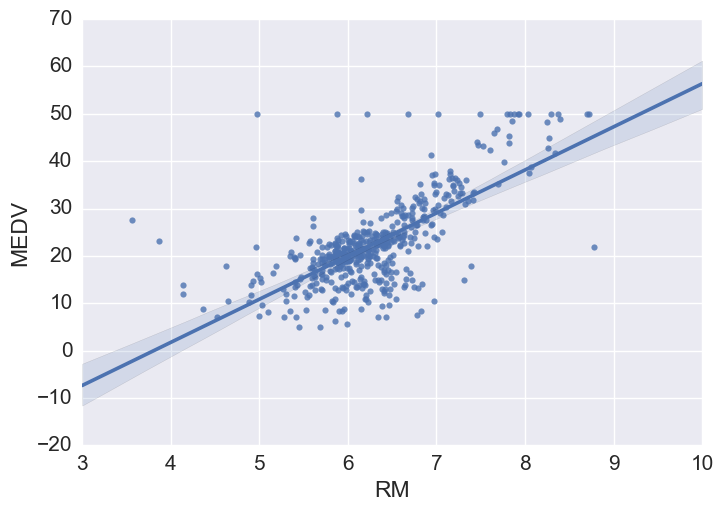

In [7]:
# Using seaborn regplot provides a quick automatic linear regression fit
sns.regplot(y="MEDV", x="RM", data=bos, fit_reg = True)

#### Price vs Crime Rate

Most houses are in a low-crime rate town. Of the low crime towns, there is a lot of variation in housing prices. However, of the houses that are in a high-crime rate town, prices tend to be on the low end.

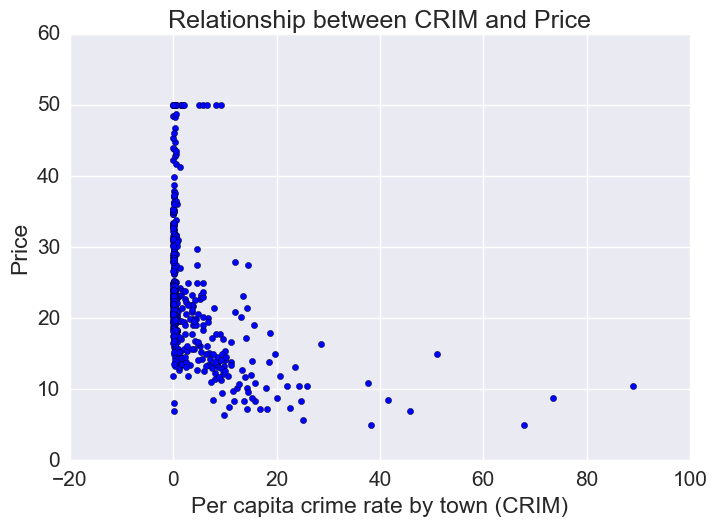

In [8]:
# How price varies as a function of per capita crime rate
plt.scatter(bos.CRIM, bos.MEDV)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Price")
plt.title("Relationship between CRIM and Price")

#### Price vs Nitric Oxide Concentrations

Nitric oxide is an air pollutant generated by cars. There is a lot of variation in NOX concentration though generally there is an inverse relationship and lower priced houses tend to be in areas of higher NOX. 

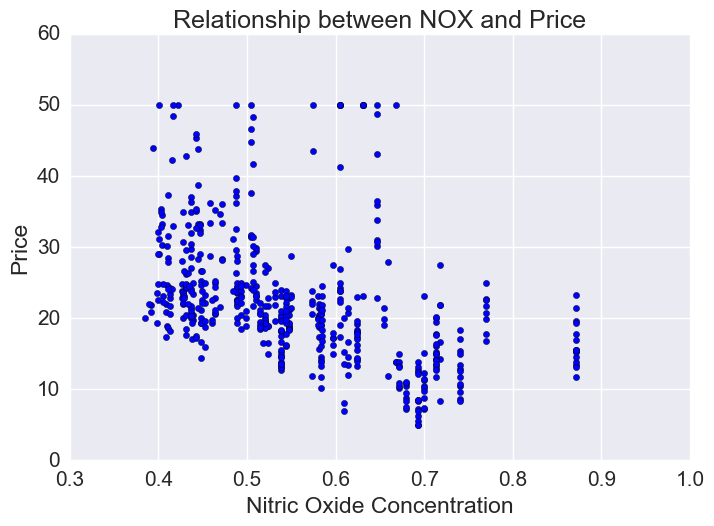

In [9]:
plt.scatter(bos.NOX, bos.MEDV)
plt.xlabel("Nitric Oxide Concentration")
plt.ylabel("Price")
plt.title("Relationship between NOX and Price")

#### Price vs percentage lower status

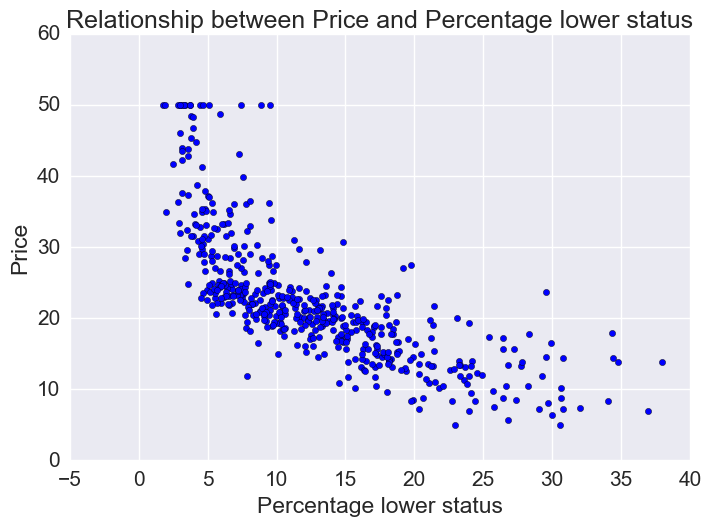

In [10]:
plt.scatter(bos.LSTAT, bos.MEDV)
plt.xlabel("Percentage lower status")
plt.ylabel("Price")
plt.title("Relationship between Price and Percentage lower status")

Let's fit linear, quadratic, and cubic polynomial models.

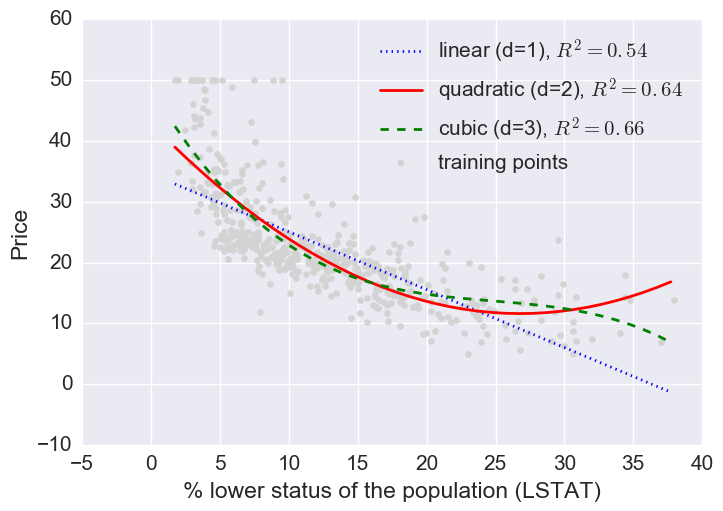

In [11]:
L = bos[['LSTAT']].values
y = bos['MEDV'].values
regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
L_quad = quadratic.fit_transform(L)
L_cubic = cubic.fit_transform(L)

# linear fit
L_fit = np.arange(L.min(), L.max(), 1)[:, np.newaxis]
regr = regr.fit(L,y)
y_lin_fit = regr.predict(L_fit)
linear_r2 = r2_score(y, regr.predict(L))

# quadratic fit
regr = regr.fit(L_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(L_fit))
quadratic_r2 = r2_score(y, regr.predict(L_quad))

# cubic fit
regr = regr.fit(L_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(L_fit))
cubic_r2 = r2_score(y, regr.predict(L_cubic))

#Plot results
plt.scatter(L, y,
           label='training points',
           color='lightgray')
plt.plot(L_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'
        % linear_r2,
        color='blue',
        lw=2,
        linestyle=':')
plt.plot(L_fit, y_quad_fit,
        label='quadratic (d=2), $R^2=%.2f$'
        % quadratic_r2,
        color='red',
        lw=2,
        linestyle='-')
plt.plot(L_fit, y_cubic_fit,
        label='cubic (d=3), $R^2=%.2f$'
        % cubic_r2,
        color='green',
        lw=2,
        linestyle='--')
plt.xlabel('% lower status of the population (LSTAT)')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

Here a log transform of the LSTAT feature and taking the sq root of the price would project the data onto a linear feature space. 

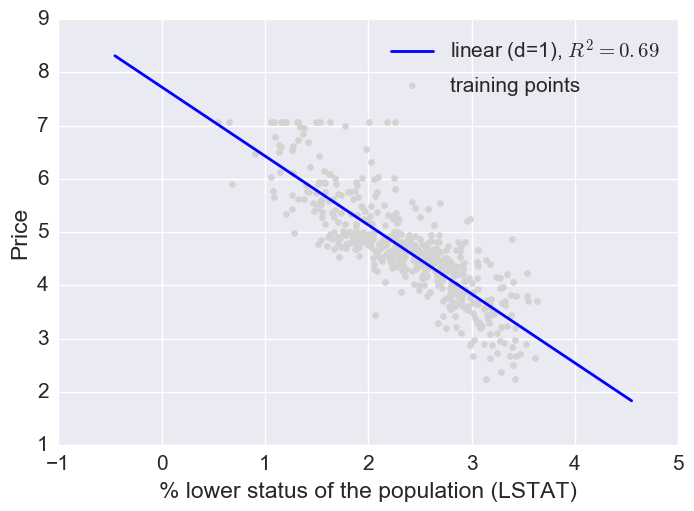

In [12]:
# Transform features
L_log = np.log(L)
y_sqrt = np.sqrt(y)

# Fit features
L_fit = np.arange(L_log.min()-1, L_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(L_log, y_sqrt)
y_lin_fit = regr.predict(L_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(L_log))

# Plot
plt.scatter(L_log, y_sqrt,
           label='training points',
           color='lightgray')
plt.plot(L_fit, y_lin_fit,
        label='linear (d=1), $R^2=%.2f$'
        % linear_r2,
        color='blue',
        lw=2)

plt.xlabel('% lower status of the population (LSTAT)')
plt.ylabel('Price')
plt.legend(loc='upper right')
plt.show()

### Fitting multiple regression models

Now let's fit a regression model with some or all of the features. First I'll use this helper function to pick the best model and hyperparameters:

In [43]:
# Models to try
models = { 
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'EN': ElasticNet(),
    'RF': RandomForestRegressor(n_estimators=1000),
    'GBR': GradientBoostingRegressor(n_estimators=1000, loss='huber')
}

# Parameters to try (this is not an exahustive GridSearch)

# Note: I'm just throwing linear regression into the GridSearch for comparison
# but not making much of an attempt effort to make it work well 
# by scaling the variables, etc.

params = { 
    'LinearRegression': { }, 
    'Ridge': { 'alpha': [.001, 0.1, 1.0] },
    'Lasso': { 'alpha': [.001, 0.1, 1.0] },
    'EN': { 'alpha': [0.1, 1.0] },
    'RF': {'max_depth': [4,6],
            'min_samples_leaf': [3, 5, 9],
            'max_features': [1.0, 0.3, 0.1]},
    'GBR': {'learning_rate': [0.1, 0.05, 0.02],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9],
              'max_features': [1.0, 0.3, 0.1]}
}

In [11]:
X = bos.drop('MEDV', axis=1) # Using all the features
y = bos['MEDV'].values # Target variable

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.3, random_state = 0)

In [45]:
helper = EstimatorSelectionHelper(models, params)
helper.fit(X_train, y_train, n_jobs=-1)

Running GridSearchCV for LinearRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Running GridSearchCV for Ridge.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Running GridSearchCV for RF.
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s


Running GridSearchCV for EN.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   10.5s finished


Running GridSearchCV for Lasso.
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.0s finished


Running GridSearchCV for GBR.
Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   27.1s finished


In [46]:
helper.score_summary()

/Users/jkim/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:52: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,estimator,min_score,mean_score,max_score,std_score,alpha,learning_rate,max_depth,max_features,min_samples_leaf
48,GBR,0.868957,0.885359,0.917223,0.0225339,NaN,0.05,4,0.3,3
43,GBR,0.850201,0.879874,0.905274,0.0226855,NaN,0.1,6,0.1,5
57,GBR,0.852843,0.878016,0.899138,0.0191154,NaN,0.05,6,0.3,3
49,GBR,0.837043,0.874952,0.908682,0.0293953,NaN,0.05,4,0.3,5
33,GBR,0.847875,0.874492,0.912369,0.0275072,NaN,0.1,4,0.1,3
75,GBR,0.842333,0.874344,0.90666,0.0262623,NaN,0.02,6,0.3,3
66,GBR,0.847384,0.874105,0.914709,0.0291856,NaN,0.02,4,0.3,3
39,GBR,0.850513,0.873563,0.90453,0.0227519,NaN,0.1,6,0.3,3
58,GBR,0.845581,0.872827,0.896801,0.0210384,NaN,0.05,6,0.3,5
52,GBR,0.832717,0.872768,0.907657,0.030811,NaN,0.05,4,0.1,5


The GBRs perform the best. In all fairness to the linear models, I could have done more to make them better, like scale and log transform some of the variables (we already saw that some of them were skewed). I also arbitrarily set n_estimators (for RandomForest and GBR) to 1000.

So I could try to optimize the hyperparameters more, but for now I'll move ahead with the highest scoring model from this GridSearch.

In [12]:
gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=.05, loss='huber', 
                                max_depth=4,max_features=.3, min_samples_leaf=3)

gbr.fit(X_train, y_train)
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

#### MAE and R^2

In [48]:
print('MAE train: %.3f, test: %.3f' % (
    mean_absolute_error(y_train, y_train_pred),
    mean_absolute_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
    (r2_score(y_train, y_train_pred),
    r2_score(y_test, y_test_pred))))

MAE train: 0.128, test: 2.410
R^2 train: 0.998, test: 0.809


It looks like we are overfitting a bit since the error is higher on the test set than the train and R^2 is lower on the test set than the train. But the model is still able to explain the relationship between the target variable and explanatory variable relatively well (R^2 =.809 on the test set).

#### Plotting residuals

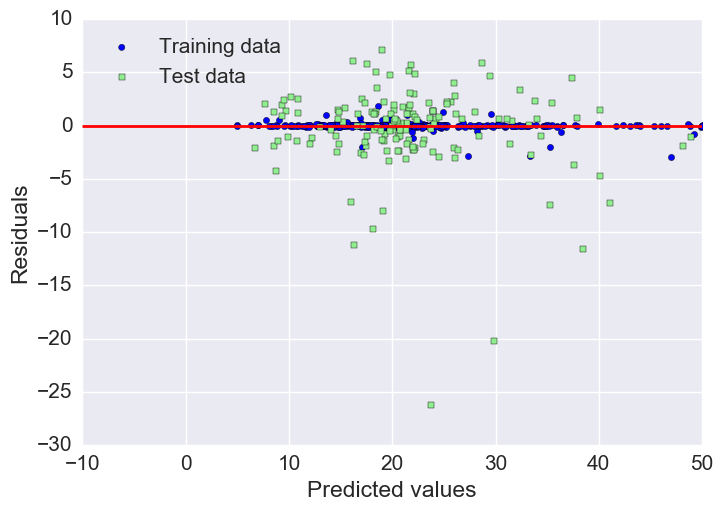

In [49]:
plt.scatter(y_train_pred, y_train_pred-y_train,
           c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred-y_test,
           c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10,50])
plt.show()

As we already saw with the MAE and R^2, we can see that the model fits the training data better than the test data, as indicated by some of the outliers in the vertical direction.

#### Feature importance

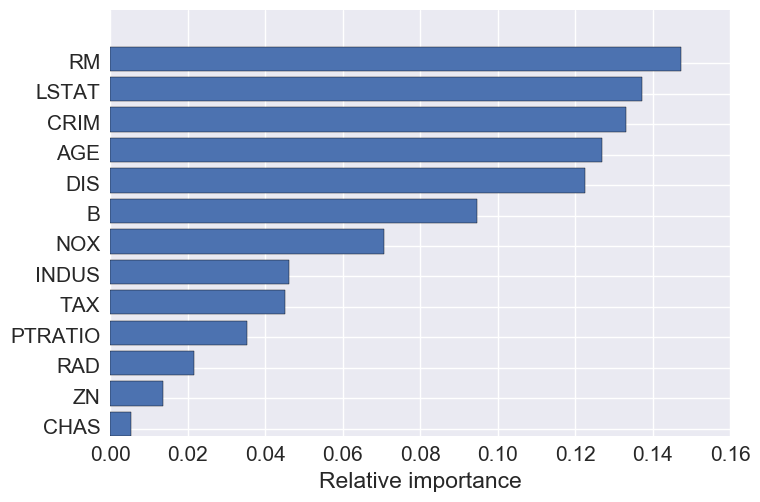

In [50]:
indices = np.argsort(gbr.feature_importances_)
names=list(X.columns.values)
plt.barh(np.arange(len(names)), gbr.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices])
_ = plt.xlabel('Relative importance')

The top 5 features are: numner of rooms, crime, percent lower status, age, and DIS- the weighted distances to five Boston employment centers.

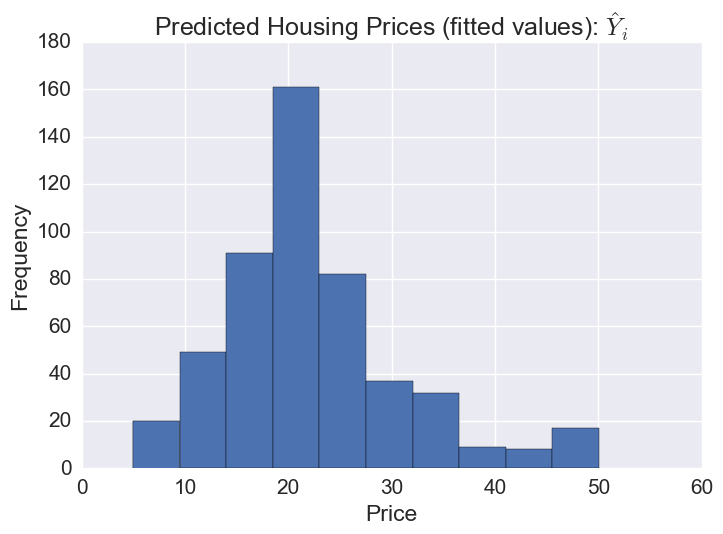

In [51]:
# The distribution of predicted prices
plt.hist(gbr.predict(X))
plt.title('Predicted Housing Prices (fitted values): $\hat{Y}_i$')
plt.xlabel('Price')
plt.ylabel('Frequency')

#### Plotting predicted prices vs prices:

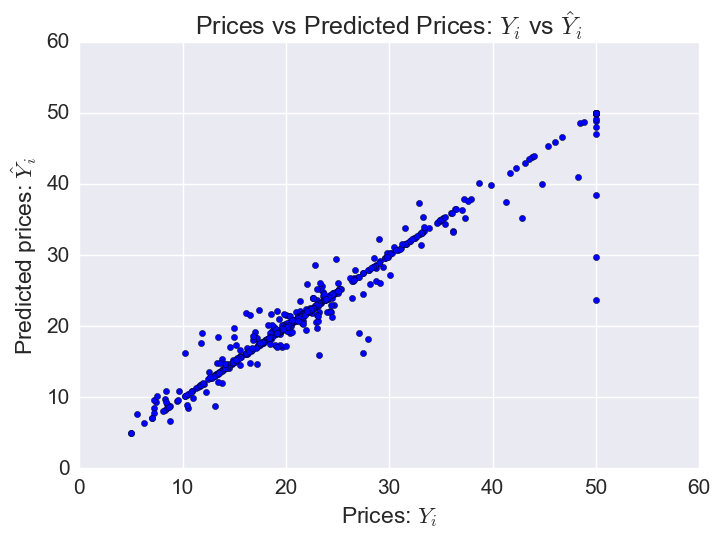

In [57]:
plt.scatter(bos.MEDV, gbr.predict(X))
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$")

The model does worst on some of the houses with the highest prices (outliers).

## Outliers

We saw here that there were some outliers in this dataset. I won't get rid of outliers here but let's look at how to predict outliers for illustration's sake.

#### Outlier detection methods
(Just looking at some of the features here.)

The empirical covariance (EllipticEnvelope) detects outliers in a Gaussian distributed dataset by fitting an ellipse around the central data points. It is highly sensitive to the heterogeneous structure of the data (it goes out of its way to fit several outliers).

The robust covariance (minimum covariance determinant) concentrates on the main mode of the data distribution (and also assumes the data is Gaussian distributed). It seems to work relatively well.

The OCSVM (One Class SVM) does unsupervised outlier detection; it does not assume any parametric form of the data distribution and can fit more complex shapes.

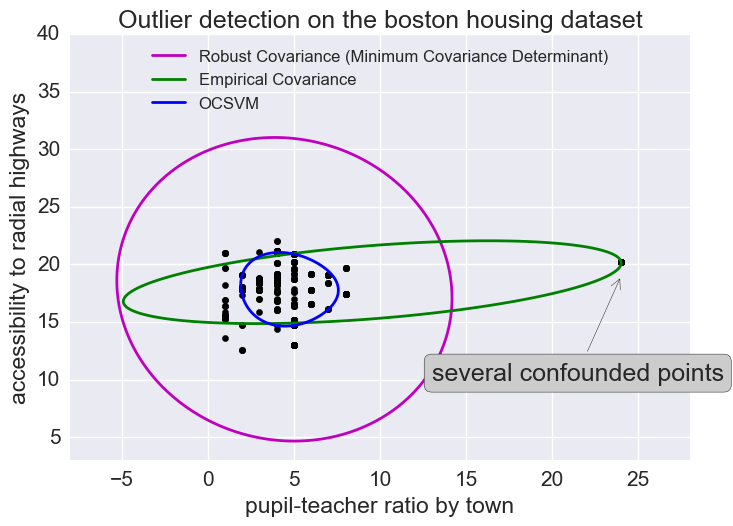

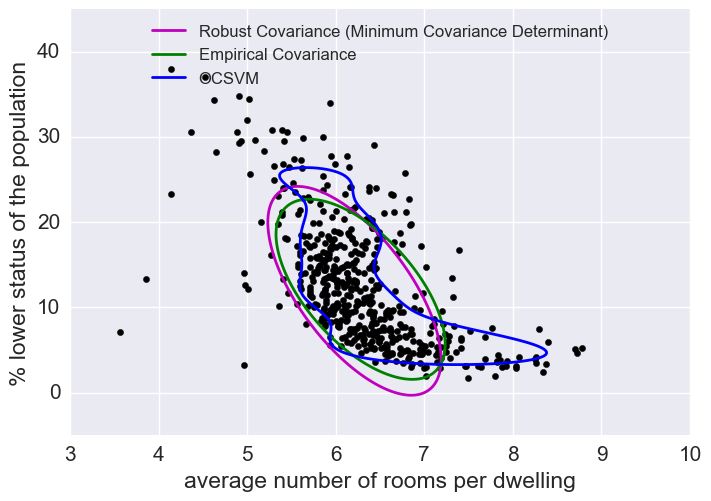

In [58]:
X1 = load_boston()['data'][:, [8, 10]]  # RAD & pupil-teacher-ratio: accessibility to radial highways
X2 = load_boston()['data'][:, [5, 12]]  # RM & LSAT: percent lower stats of the population

# Define "classifiers" to be used
classifiers = {
    "Empirical Covariance": EllipticEnvelope(support_fraction=1., #support_fraction = the proportion of points to be included in the support of the estimate
                                             contamination=0.261),
    "Robust Covariance (Minimum Covariance Determinant)": EllipticEnvelope(contamination=0.261),
    "OCSVM": OneClassSVM(nu=0.261, gamma=0.05)}
colors = ['m', 'g', 'b']
legend1 = {}
legend2 = {}
#legend3 = {}

# Outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))
xx2, yy2 = np.meshgrid(np.linspace(3, 10, 500), np.linspace(-5, 45, 500))
xx3, yy3 = np.meshgrid(np.linspace(-8, 28, 500), np.linspace(3, 40, 500))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    plt.figure(1)
    clf.fit(X1)
    Z1 = clf.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
    Z1 = Z1.reshape(xx1.shape)
    legend1[clf_name] = plt.contour(
        xx1, yy1, Z1, levels=[0], linewidths=2, colors=colors[i])
    
    plt.figure(2)
    clf.fit(X2)
    Z2 = clf.decision_function(np.c_[xx2.ravel(), yy2.ravel()])
    Z2 = Z2.reshape(xx2.shape)
    legend2[clf_name] = plt.contour(
        xx2, yy2, Z2, levels=[0], linewidths=2, colors=colors[i])
    '''
    plt.figure(3)
    clf.fit(X3)
    Z3 = clf.decision_function(np.c_[xx3.ravel(), yy3.ravel()])
    Z3 = Z3.reshape(xx3.shape)
    legend3[clf_name] = plt.contour(
        xx3, yy3, Z3, levels=[0], linewidths=2, colors=colors[i])
    '''
    
legend1_values_list = list(legend1.values())
legend1_keys_list = list(legend1.keys())

# Plot the results 
plt.figure(1)  
plt.title("Outlier detection on the boston housing dataset")
plt.scatter(X1[:, 0], X1[:, 1], color='black')
bbox_args = dict(boxstyle="round", fc="0.8")
arrow_args = dict(arrowstyle="->")
plt.annotate("several confounded points", xy=(24, 19),
             xycoords="data", textcoords="data",
             xytext=(13, 10), bbox=bbox_args, arrowprops=arrow_args)
plt.xlim((xx1.min(), xx1.max()))
plt.ylim((yy1.min(), yy1.max()))
plt.legend((legend1_values_list[0].collections[0],
            legend1_values_list[1].collections[0],
            legend1_values_list[2].collections[0]),
           (legend1_keys_list[0], legend1_keys_list[1], legend1_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("accessibility to radial highways")
plt.xlabel("pupil-teacher ratio by town")

legend2_values_list = list(legend2.values())
legend2_keys_list = list(legend2.keys())

plt.figure(2)  # "banana" shape
plt.scatter(X2[:, 0], X2[:, 1], color='black')
plt.xlim((xx2.min(), xx2.max()))
plt.ylim((yy2.min(), yy2.max()))
plt.legend((legend2_values_list[0].collections[0],
            legend2_values_list[1].collections[0],
            legend2_values_list[2].collections[0]),
           (legend2_keys_list[0], legend2_keys_list[1], legend2_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")

'''
legend3_values_list = list(legend3.values())
legend3_keys_list = list(legend3.keys())

plt.figure(3)  
plt.scatter(X3[:, 0], X3[:, 1], color='black')
plt.xlim((xx3.min(), xx3.max()))
plt.ylim((yy3.min(), yy3.max()))
plt.legend((legend3_values_list[0].collections[0],
            legend3_values_list[1].collections[0],
            legend3_values_list[2].collections[0]),
           (legend3_keys_list[0], legend3_keys_list[1], legend3_keys_list[2]),
           loc="upper center",
           prop=matplotlib.font_manager.FontProperties(size=12))
plt.ylabel("% lower status of the population")
plt.xlabel("average number of rooms per dwelling")
'''
plt.show()